In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8,9'
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import dei_utils as Dei
import numpy as np

In [21]:
def hierarchical_clustering(dist, k, method='single'):
    """
    层次聚类算法实现
    
    参数:
    dist -- 距离矩阵，形状为 (n, n)，是一个PyTorch tensor
    k -- 最终需要的簇的数量
    method -- 距离计算方式，'single', 'complete', 'average'
    
    返回:
    clusters -- 每个数据点的簇主ID
    """
    # dist=1-dist
    dist = dist * 100
    # 获取数据点的个数
    n = dist.shape[0]
    
    # 初始化簇，最初每个数据点是一个簇
    clusters = [[i] for i in range(n)]
    
    # 初始化距离矩阵，dist矩阵中的元素是所有簇之间的距离
    while len(clusters) > k:
        min_dist = float('inf')
        merge_i, merge_j = -1, -1
        
        # 找到距离最近的两个簇
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                # 获取两个簇之间的距离
                cluster_i = clusters[i]
                cluster_j = clusters[j]
                
                if method == 'single' or 'min':
                    # 单链接：簇间最小距离
                    distance = torch.min(dist[torch.tensor(cluster_i).unsqueeze(1), torch.tensor(cluster_j)])
                elif method == 'complete' or 'max':
                    # 完全链接：簇间最大距离
                    distance = torch.max(dist[torch.tensor(cluster_i).unsqueeze(1), torch.tensor(cluster_j)])
                elif method == 'average' or 'avg':
                    # 平均链接：簇间所有对的平均距离
                    distance = torch.mean(dist[torch.tensor(cluster_i).unsqueeze(1), torch.tensor(cluster_j)])
                else:
                    raise ValueError("Method must be one of 'single', 'complete', or 'average'")
                
                # 记录最小的簇间距离
                if distance < min_dist:
                    min_dist = distance
                    merge_i, merge_j = i, j
        
        # 合并这两个簇
        clusters[merge_i].extend(clusters[merge_j])  # 合并簇
        del clusters[merge_j]  # 删除合并的簇
    
    # 为每个簇分配簇主（簇内最小的ID）
    cluster_leader = {}
    for cluster in clusters:
        leader = min(cluster)  # 选择簇内最小的ID作为簇主
        for idx in cluster:
            cluster_leader[idx] = leader  # 每个数据点的簇主是该簇的最小ID
    
    # 返回每个点的簇主ID
    cluster_assignments = torch.tensor([cluster_leader[i] for i in range(n)], dtype=torch.long)
    
    return cluster_assignments

ss='exp_mse'
# ss='rou_mse'
linkage = 'max'
retention = 4

a=Dei.load(f'dist/{ss}')

l=[]
for i in range(32):
    l.append(hierarchical_clustering(a[i],6,linkage))
b=torch.stack(l)
print(b.shape)
Dei.save(b,f'group/{ss}_{retention}_{linkage}')


torch.Size([32, 8])
Saving tensor to /new_data/yanghq/data/group/exp_mse_4_max.pt


In [7]:
import dei_utils as Dei
a=Dei.load('dist/rou_mse')
a=Dei.load('dist/exp_mse')
a=a*100
a.min(),a.max()

(tensor(0.), tensor(0.0238))

In [ ]:
import dei_utils as Dei
r=['exp','rou']
s=['mse','cos']
num=[4,6]
link=['avg','min','max']
for rr in r:
    for ss in s:
        for nn in num:
            for ll in link:
                s=f'group/{rr}_{ss}_{nn}_{ll}'
a=Dei.load('group/exp_mse_4_avg')
b=Dei.load('group/exp_mse_4_max')
# b=Dei.load('group/rou_mse_4_avg')
print(a[6:9])
print(b[6:9])

tensor([[0, 1, 0, 0, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 1, 1],
        [0, 1, 2, 3, 4, 1, 1, 7]])
tensor([[0, 1, 0, 0, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 1, 1],
        [0, 1, 2, 3, 4, 1, 1, 7]])


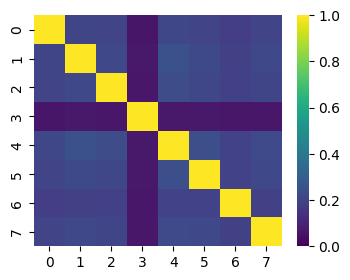

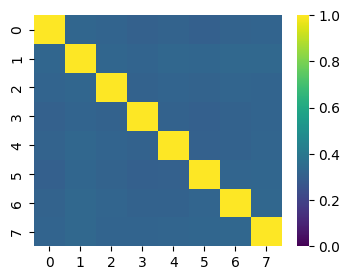

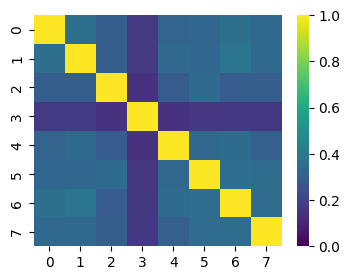

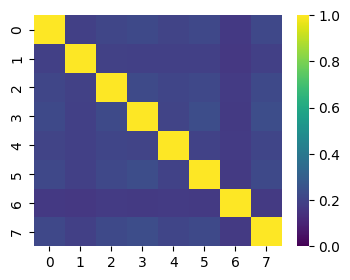

In [24]:
def plot_heatmap(tensor):
    plt.figure(figsize=(4, 3))
    sns.heatmap(tensor.numpy(), cmap='viridis', 
                vmin=0, vmax=1,
                # , fmt='.2f', annot=True
                )
    plt.show()
a = Dei.load('dist/exp_cos')
plot_heatmap(a[1])
plot_heatmap(a[7])
plot_heatmap(a[11])
plot_heatmap(a[26])

# a = Dei.load('dist/rou_cos')
# plot_heatmap(a[1])
# plot_heatmap(a[7])
# plot_heatmap(a[11])
# plot_heatmap(a[26])
